In [1]:
from dqn.agent import CarRacingDQN
import os
import tensorflow as tf
import gym
import _thread
import re
import sys

import h5py

from matplotlib import pyplot as plt

import numpy as np

import pickle

from collections import Counter
from sklearn.utils import resample

from sklearn.tree import DecisionTreeClassifier

import glob

track_type = 'Cycle'

if track_type == 'Square':
    checkpoint_path = 'data/square_20210608'
elif track_type == 'Ellipse':
    checkpoint_path = 'data/ellipse_20210608'
elif track_type == 'ZigZag':
    checkpoint_path = 'data/zigzag_20210608'
elif track_type == 'Cycle':
    checkpoint_path = '/home/dahlin/Desktop/Car Racing/DQN/data/checkpoint_20210225_num_frame_stack_1_frame_skip_3/Checkpoints'

/home/dahlin/Desktop/Car Racing/car_racing_retry/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/dahlin/Desktop/Car Racing/car_racing_retry/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/dahlin/Desktop/Car Racing/car_racing_retry/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/hom

In [2]:
if track_type != 'Combine':
    #rollout_files = sorted(glob.glob("data/checkpoint02/dqn*.h5"),key=os.path.getmtime)
    rollout_files = sorted(glob.glob(os.path.join(checkpoint_path,'dqn*.h5')),key=os.path.getmtime)
    print('Loading '+rollout_files[-1])
    f = h5py.File(rollout_files[-1],'r')
    actions_rollout = f['actions_rollout'][:]
    frames_rollout = f['frames_rollout'][:]
    f.close()
else:
    actions_rollout = []
    frames_rollout = []
    for checkpoint_path in ['data/square_20210608','data/ellipse_20210608','data/zigzag_20210608']:
        rollout_files = sorted(glob.glob(os.path.join(checkpoint_path,'dqn*.h5')),key=os.path.getmtime)
        print('Loading '+rollout_files[-1])
        f = h5py.File(rollout_files[-1],'r')
        actions_rollout.extend(f['actions_rollout'][:])
        actions_rollout.extend(f['actions_rollout'][:])
        frames_rollout.extend(f['frames_rollout'][:])
        frames_rollout.extend(f['frames_rollout'][:])
        actions_rollout.extend(f['actions_rollout'][:])
        actions_rollout.extend(f['actions_rollout'][:])
        frames_rollout.extend(f['frames_rollout'][:])
        frames_rollout.extend(f['frames_rollout'][:])
        f.close()
    actions_rollout = np.array(actions_rollout)
    frames_rollout = np.array(frames_rollout)

print(actions_rollout.shape)
print(frames_rollout.shape)

Loading /home/dahlin/Desktop/Car Racing/DQN/data/checkpoint_20210225_num_frame_stack_1_frame_skip_3/Checkpoints/dqn_rollouts_20210610_1150.h5
(2774,)
(2774, 96, 96)


actions rollout shape: (2774,)
frames rollout shape: (2774, 96, 96)
actions rollout shape: (2774,)
frames rollout shape: (2774, 96, 96)
(277, 96, 96) (277,) (2497, 96, 96) (2497,)


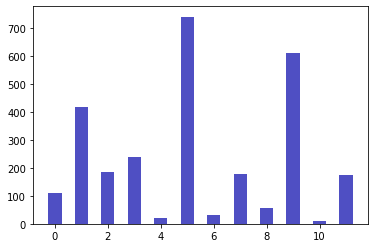

In [3]:
print('actions rollout shape: '+str(actions_rollout.shape))
print('frames rollout shape: '+str(frames_rollout.shape))

hist,bin_edges = np.histogram(actions_rollout,bins=[0, 1, 2, 3,4,5,6,7,8,9,10,11,12])
plt.bar(bin_edges[:-1], hist, width = 0.5, color='#0504aa',alpha=0.7)

actions_rollout,frames_rollout = resample(actions_rollout,frames_rollout,replace=False)
#frames_rollout = resample(frames_rollout,replace=False)

print('actions rollout shape: '+str(actions_rollout.shape))
print('frames rollout shape: '+str(frames_rollout.shape))

# hold out training samples for validation
#valid_frac = 0.2
valid_frac = 0.1
num_valid = int(np.round(len(actions_rollout)*valid_frac))
num_train = int(np.round(len(actions_rollout)*(1-valid_frac)))
frames_valid, actions_valid = frames_rollout[-num_valid:], actions_rollout[-num_valid:]
frames_train, actions_train = frames_rollout[:-num_valid], actions_rollout[:-num_valid]
print(frames_valid.shape,actions_valid.shape,frames_train.shape,actions_train.shape)

In [4]:
n_classes = 12

# convert labels to 1-hot vectors
#actions_train = tf.keras.utils.to_categorical(actions_train, n_classes)
#actions_valid = tf.keras.utils.to_categorical(actions_valid, n_classes)

## normalize inputs and cast to float
#frames_train = (frames_train / np.max(frames_train)).astype(np.float32)
#frames_valid = (frames_valid / np.max(frames_valid)).astype(np.float32)

frames_train_flat = frames_train.reshape((frames_train.shape[0], -1))
frames_valid_flat = frames_valid.reshape((frames_valid.shape[0], -1))

In [5]:
#savepath = 'hard_trees_features'+str(num_data_points)
if track_type != 'Combine':
    savepath = checkpoint_path+'/Students/HDT/hard_trees_frames_'+str(num_train)+'_train_points'
else:
    savepath = 'data/Combine/Students/HDT/hard_trees_frames_'+str(num_train)+'_train_points'

if not os.path.exists(savepath):
    os.makedirs(savepath)

train_accs = []
val_accs = []

for depth in range(2,21):

    print('Tree Depth: '+str(depth))

    student = DecisionTreeClassifier(max_depth=depth,class_weight='balanced')
    student.fit(frames_train_flat,actions_train)

    train_acc=student.score(frames_train_flat,actions_train)
    val_acc=student.score(frames_valid_flat,actions_valid)

    print('Train accuracy: '+str(train_acc))
    print('Valid accuracy: '+str(val_acc))

    train_accs.append(train_acc)
    val_accs.append(val_acc)

    list_pickle = open(savepath+'/'+'hard_tree_depth_'+str(depth)+'_balanced.pkl','wb')
    pickle.dump(student,list_pickle)
    list_pickle.close()

with open(os.path.join(savepath,'accuracy_data.pkl'),'wb') as f:
    pickle.dump([train_accs,val_accs],f)

Tree Depth: 2
Train accuracy: 0.10252302763315979
Valid accuracy: 0.10108303249097472
Tree Depth: 3
Train accuracy: 0.040048057669203045
Valid accuracy: 0.02527075812274368
Tree Depth: 4
Train accuracy: 0.05847016419703644
Valid accuracy: 0.05054151624548736
Tree Depth: 5
Train accuracy: 0.10612735282338806
Valid accuracy: 0.11191335740072202
Tree Depth: 6
Train accuracy: 0.1726071285542651
Valid accuracy: 0.18050541516245489
Tree Depth: 7
Train accuracy: 0.38446135362434924
Valid accuracy: 0.4007220216606498
Tree Depth: 8
Train accuracy: 0.41489787745294354
Valid accuracy: 0.4404332129963899
Tree Depth: 9
Train accuracy: 0.5158189827793352
Valid accuracy: 0.555956678700361
Tree Depth: 10
Train accuracy: 0.5802963556267521
Valid accuracy: 0.592057761732852
Tree Depth: 11
Train accuracy: 0.6439727673207849
Valid accuracy: 0.6425992779783394
Tree Depth: 12
Train accuracy: 0.6752102523027633
Valid accuracy: 0.6389891696750902
Tree Depth: 13
Train accuracy: 0.7601121345614738
Valid accurac

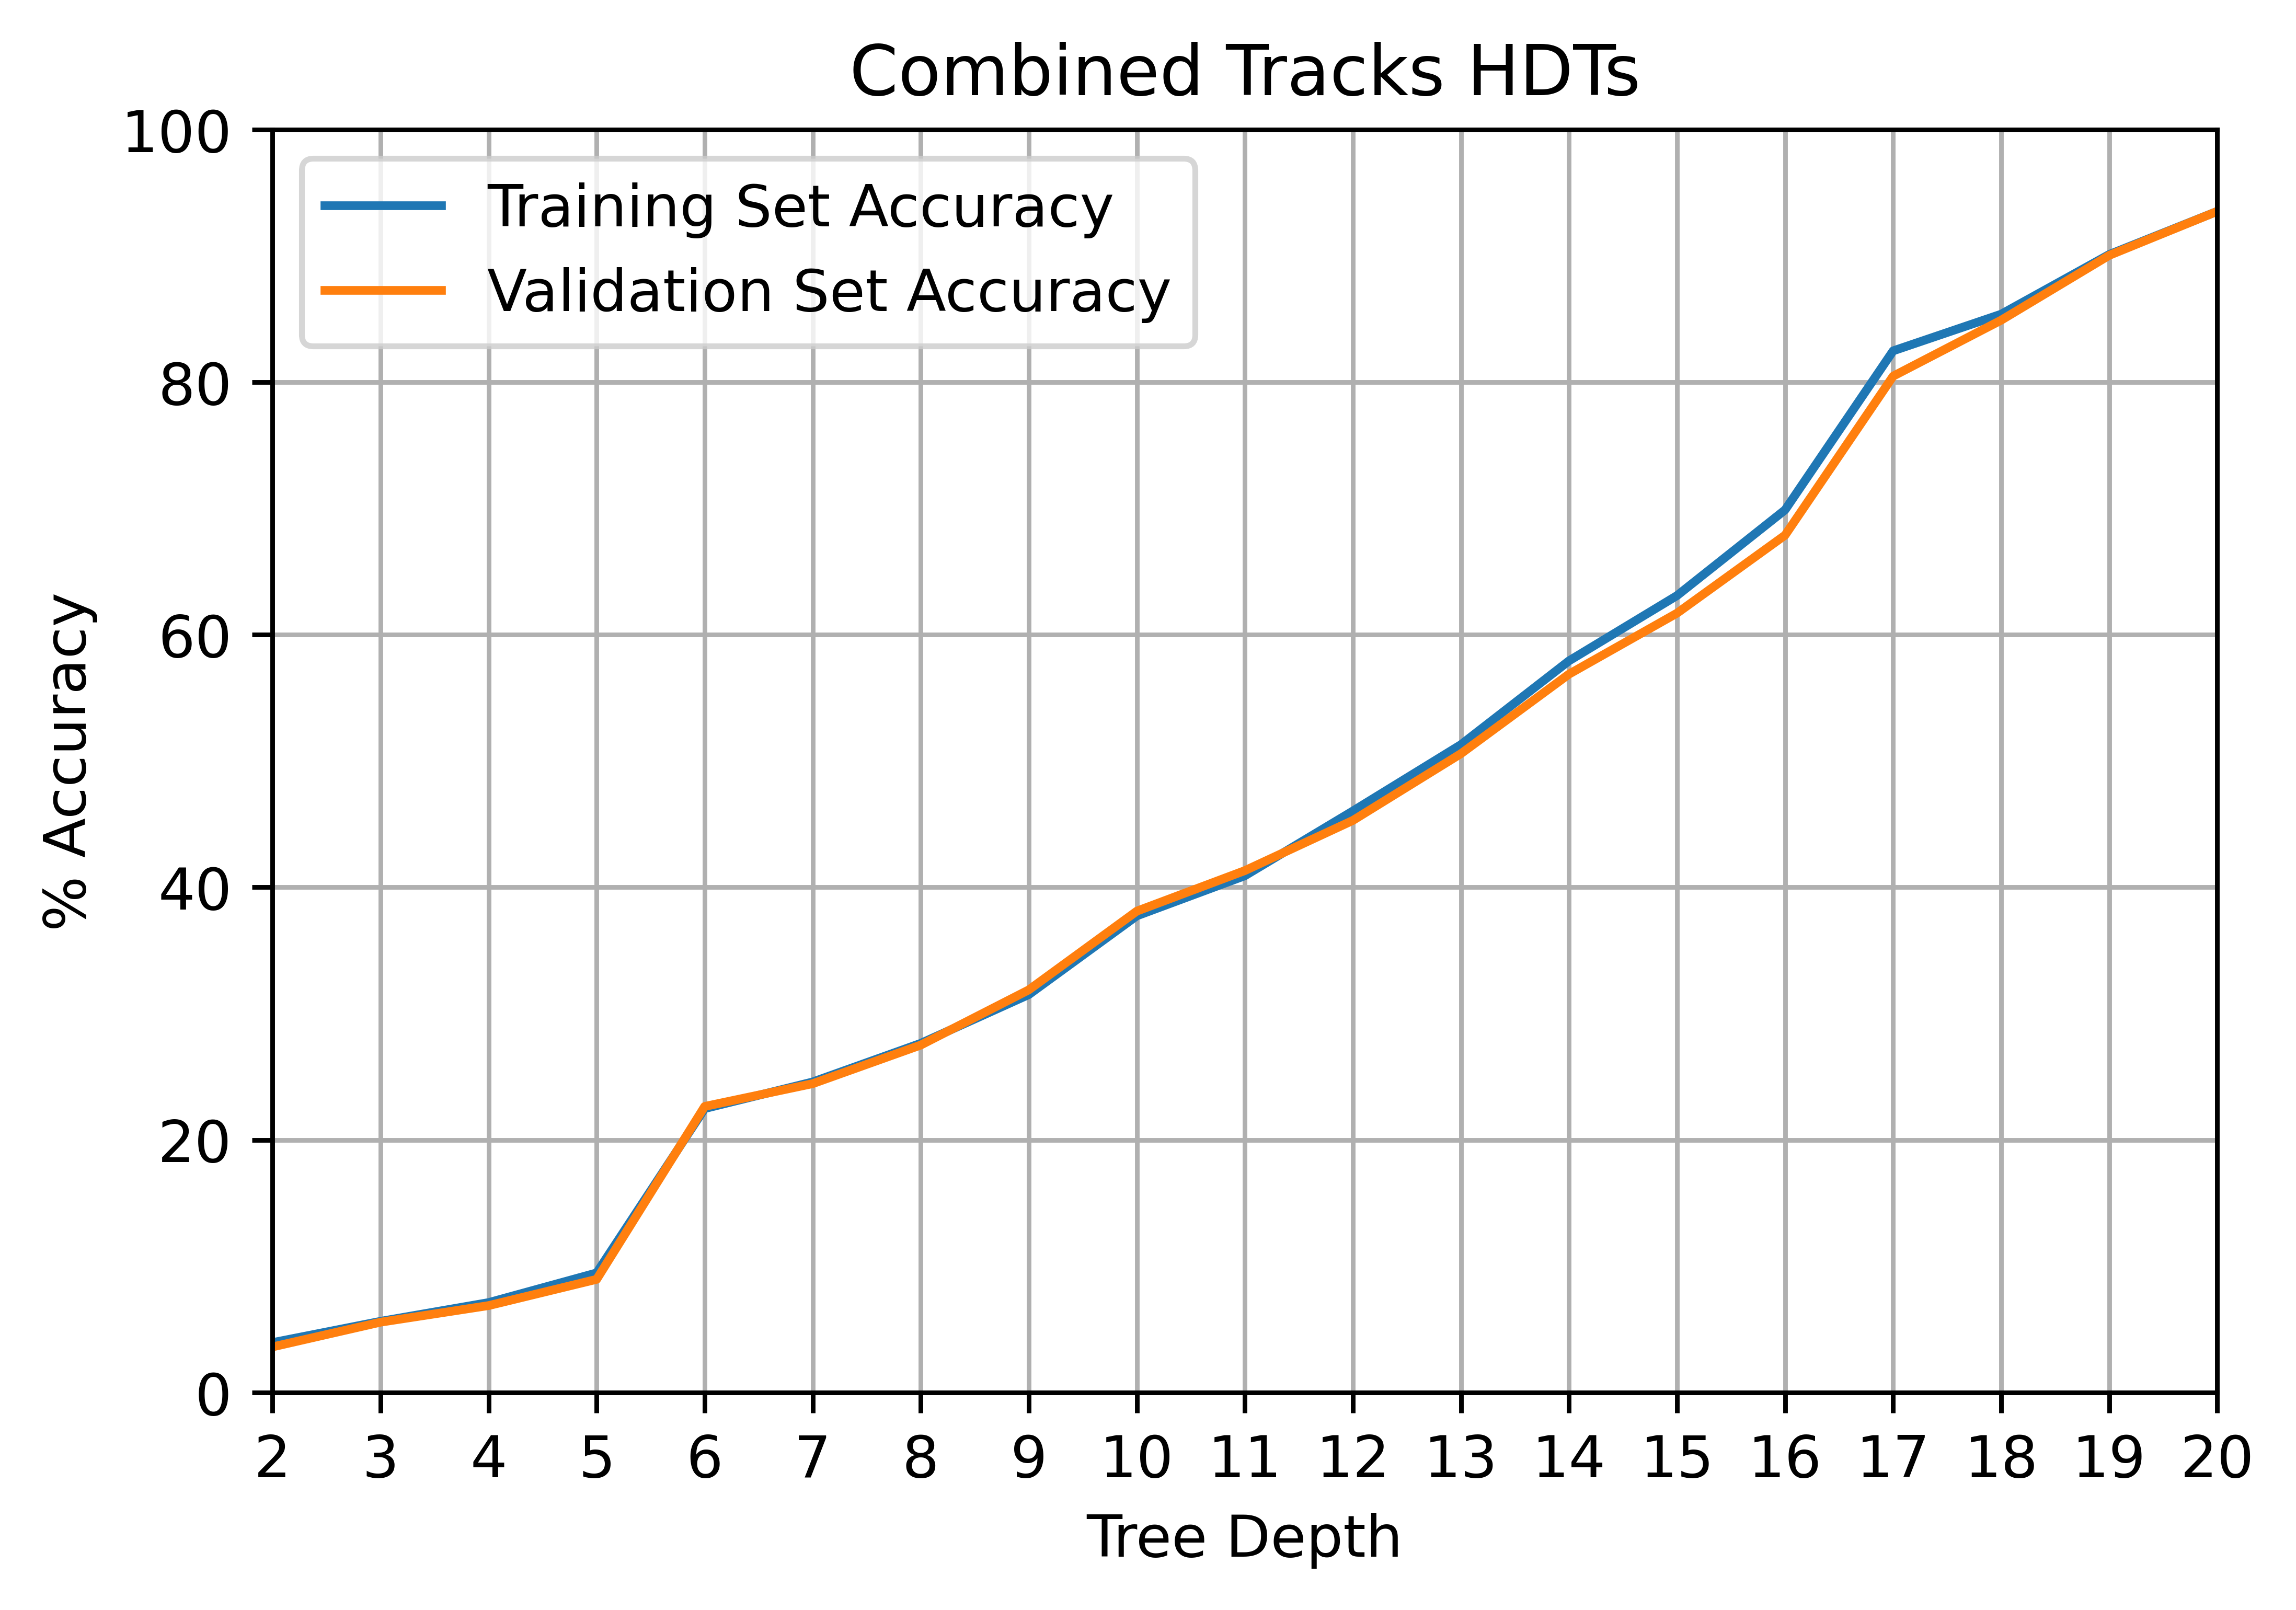

In [6]:
plt.figure(dpi=800)
tree_depths = np.array(range(2,21))
plt.plot(tree_depths,np.array(train_accs)*100,label='Training Set Accuracy')
plt.plot(tree_depths,np.array(val_accs)*100,label='Validation Set Accuracy')
#plt.plot(tree_depths,np.array(train_accs),label='Training Set Accuracy')
#plt.plot(tree_depths,np.array(val_accs),label='Validation Set Accuracy')
plt.xticks(tree_depths)
plt.xlabel('Tree Depth')
plt.ylabel('% Accuracy')
plt.xlim((2,20))
plt.ylim((0,100))
plt.legend()
plt.grid()
if track_type == 'Square':
    plt.title('Square Track HDTs')
elif track_type == 'Ellipse':
    plt.title('Elliptical Track HDTs')
elif track_type == 'ZigZag':
    plt.title('ZigZag Track HDTs')
elif track_type == 'Combine':
    plt.title('Combined Tracks HDTs')
fig_savepath = os.path.join(savepath,track_type+'_accuracy_plot.jpg')
plt.savefig(fig_savepath)